<div style="display: flex; background-color: #ad283c;" >
<h1 style="margin: auto; padding: 30px; ">ANALYSE DU STOCK ET DES VENTES DU SITE BOTTLENECK</h1>
</div>

# OBJECTIF DE CE NOTEBOOK

Les objectifs sont les suivants :

- Explorer les données fournies
- Améliorer le workflow
- Repérer les erreurs dans la base de données



<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 - Importation des librairies</h3>
</div>

In [1]:
#Importation de la librairie Pandas
import pandas as pd

# Importation de numpy
import numpy as np

#Importation de la librairie plotly express
import plotly.express as px

# Importation de matplotlib (nécessaire pour les graphiques pandas)
import matplotlib.pyplot as plt

# Importation de Seaborn
import seaborn as sns

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Chargements des fichiers</h3>
</div>

In [2]:
# Desactivation des warnings pour l'import des fichiers
import warnings
from openpyxl.utils.exceptions import InvalidFileException

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [3]:
#Importation du fichier web.xlsx
df_web = pd.read_excel("./source_data/web.xlsx", engine="openpyxl")
#Importation du fichier erp.xlsx
df_erp = pd.read_excel("./source_data/erp.xlsx", engine="openpyxl")
#Importation du fichier liaison.xlsx
df_liaison = pd.read_excel("./source_data/liaison.xlsx", engine="openpyxl")

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse exploratoire des fichiers</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1 - Analyse exploratoire du fichier erp.xlsx</h3>
</div>

In [4]:
#Afficher les dimensions du dataset
print(f"Le tableau comporte {df_erp.shape[0]} observation(s) ou article(s)")
print(f"Le tableau comporte {df_erp.shape[1]} colonne(s)")

Le tableau comporte 825 observation(s) ou article(s)
Le tableau comporte 6 colonne(s)


In [5]:
#Consulter les colonnes
#La nature des données dans chacune des colonnes
#Le nombre de valeurs présentes dans chacune des colonnes
print(10 * "-" + " Informations du fichier ERP " + 10 * "-" + "\n")
df_erp.info()


---------- Informations du fichier ERP ----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
 5   purchase_price  825 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 38.8+ KB


In [6]:
#Afficher les 5 premières lignes de la table
df_erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price
0,3847,1,24.2,16,instock,12.88
1,3849,1,34.3,10,instock,17.54
2,3850,1,20.8,0,outofstock,10.64
3,4032,1,14.1,26,instock,6.92
4,4039,1,46.0,3,outofstock,23.77


In [7]:
#Vérifier si il y a des lignes en doublon dans la colonne product_id
df_erp[df_erp.duplicated(subset=['product_id'], keep=False)]

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price


In [8]:
#Afficher les valeurs distinctes de la colonne stock_status
print(pd.unique(df_erp['stock_status']))

#À quelle(s) autre(s) colonne(s) sont-elles liées ?
# stock_quantity

['instock' 'outofstock']


In [9]:
#Création d'une colonne "stock_status_2"
#La valeur de cette deuxième colonne sera fonction de la valeur dans la colonne "stock_quantity"
#Si la valeur de la colonne "stock_quantity" est nulle, renseigner "outofstock" sinon mettre "instock"
df_erp['stock_status_2'] = np.where(
    df_erp['stock_quantity'] > 0,
    'instock',
    'outofstock'
)
df_erp['stock_status_2']

0         instock
1         instock
2      outofstock
3         instock
4         instock
          ...    
820       instock
821       instock
822       instock
823       instock
824       instock
Name: stock_status_2, Length: 825, dtype: object

In [10]:
#Vérifions que les 2 colonnes sont identiques:
#Les 2 colonnes sont strictement identiques si les valeurs de chaque ligne sont strictement identiques 2 à 2
#La comparaison de 2 colonnes peut se réaliser simplement avec l'instruction ci-dessous:
df_erp["stock_status"] == df_erp["stock_status_2"]

#Le résultat est l'affichage de True ou False pour chacune des lignes du dataset
#C'est un bon début, mais difficile à exploiter

0       True
1       True
2       True
3       True
4      False
       ...  
820     True
821     True
822     True
823     True
824     True
Length: 825, dtype: bool

In [11]:
#Mais il est possible de synthétiser ce résultat en effectuant la somme de cette colonne:
#True vaut 1 et False 0
#Nous devrions obtenir la somme de 824 qui correspond au nombre de lignes dans ce dataset
print(f"{(df_erp["stock_status"] == df_erp["stock_status_2"]).sum()} valeurs correctes dans la colonne stock_status sur {len(df_erp)}")

823 valeurs correctes dans la colonne stock_status sur 825


In [12]:
#Si les colonnes ne sont absolument pas identiques ligne à ligne alors identifier la ligne en écart
incoherence_stock: pd.DataFrame = df_erp[df_erp['stock_status'] != df_erp['stock_status_2']]
incoherence_stock

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price,stock_status_2
4,4039,1,46.0,3,outofstock,23.77,instock
398,4885,1,18.7,0,instock,9.66,outofstock


In [13]:
#Corriger la ou les données incohérentes
df_erp.rename(columns={'stock_status': 'stock_status_original'}, inplace=True)
df_erp.rename(columns={'stock_status_2': 'stock_status'}, inplace=True)
df_erp
# Je ne modifie pas les colonnes d'origine pour garder une cohérence des données
# A la place je renomme les colonnes pour pouvoir les manipuler avec plus de facilités après

,product_id,onsale_web,price,stock_quantity,stock_status_original,purchase_price,stock_status
0,3847,1,24.2,16,instock,12.88,instock
1,3849,1,34.3,10,instock,17.54,instock
2,3850,1,20.8,0,outofstock,10.64,outofstock
3,4032,1,14.1,26,instock,6.92,instock
4,4039,1,46.0,3,outofstock,23.77,instock
...,...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,23.48,instock
821,7204,0,45.0,9,instock,24.18,instock
822,7247,1,54.8,6,instock,27.18,instock
823,7329,0,26.5,14,instock,13.42,instock


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1 - Analyse exploratoire de chaque variable du fichier erp.xlsx</h3>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.1 - Analyse de la variable PRIX</h3>
</div>

In [14]:
###############
## LES PRIX  ##
###############

#Vérification des prix: Y a t-il des prix non renseignés, négatifs ou nuls?
#Afficher le ou les prix non renseignés dans la colonne "price"
prix_invalides: pd.Series = df_erp['price'] <= 0
prix_manquant: pd.Series = df_erp['price'].isna()
filtre_prix_incorrect = (prix_invalides | prix_manquant)
nombre_articles_invalides: np.int64 = filtre_prix_incorrect.sum()
print(f"Nombres d'articles avec un prix mal renseigné: {nombre_articles_invalides}") 

#Afficher le prix minimum de la colonne "price"
print(f"Prix minimum dans la colonne price : {df_erp['price'].min()}")

#Afficher le prix maximum de la colonne "price"
print(f"Prix maximum dans la colonne price : {df_erp['price'].max()}")

#Afficher les prix inférieurs à 0 (qu'est-ce qu'il faut en faire ?)
df_erp[filtre_prix_incorrect]


Nombres d'articles avec un prix mal renseigné: 3
Prix minimum dans la colonne price : -20.0
Prix maximum dans la colonne price : 225.0


,product_id,onsale_web,price,stock_quantity,stock_status_original,purchase_price,stock_status
151,4233,0,-20.0,0,outofstock,10.33,outofstock
469,5017,0,-8.0,0,outofstock,4.34,outofstock
739,6594,0,-9.1,19,instock,4.61,instock


Plusieurs solutions s'offrent à nous pour gérer ces cas :
- Les retirer de la vente termporairement 
- Supprimer les lignes et retirer de la vente définitevement (solution la moins envisageable)
- Mettre des prix justes au dessus du prix d'achat afin de pouvoir vendre ces produits

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.2 - Analyse de la variable STOCK</h3>
</div>

In [15]:
#######################
### stock_quantity  ###
#######################

#Vérification de la colonne stock quantity
#Afficher la quantité minimum de la colonne "stock_quantity"
print(f"Nombre minimum de stock : {df_erp['stock_quantity'].min()}")

#Afficher la quantité maximum de la colonne "stock_quantity"
print(f"Nombre maximum de stock : {df_erp['stock_quantity'].max()}")

#Afficher les stocks inférieurs à 0 (qu'est-ce qu'il faut en faire ?)
print("\nStock avec des valeurs absurdes :")
df_erp[df_erp['stock_quantity'] < 0]


Nombre minimum de stock : -10
Nombre maximum de stock : 145

Stock avec des valeurs absurdes :


,product_id,onsale_web,price,stock_quantity,stock_status_original,purchase_price,stock_status
449,4973,0,10.0,-10,outofstock,4.96,outofstock
573,5700,1,44.5,-1,outofstock,22.30,outofstock


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.3 - Analyse de la variable ONSALE_WEB</h3>
</div>

In [16]:
# Vérification de la colonne onsale_web et des valeurs qu'elle contient. Que signifient-elles?
print(pd.unique(df_erp["onsale_web"]))

[1 0]


Ne contenant que des 0 ou des 1, cette colonne peut signifier plusieurs choses :
- De savoir si le produit est en vente actuellement ou non
- De savoir si le produit est en solde

In [17]:
#Quelles sont les colonnes à conserver selon vous?

Les colonnes à conserver sont : 
- product_id
- onsale_web
- price
- stock_quantity
- purchase_price

stock_status peut être théoriquement supprimé car c'est une valeur déduite de la colonne stock_quantity

In [18]:
#Supprimer la colonne comportant le libellé "stock_status_2" car elle est redondante 
#avec la colonne "stock_status".
df_erp = df_erp.drop(columns=['stock_status_original'])
df_erp.head()

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status
0,3847,1,24.2,16,12.88,instock
1,3849,1,34.3,10,17.54,instock
2,3850,1,20.8,0,10.64,outofstock
3,4032,1,14.1,26,6.92,instock
4,4039,1,46.0,3,23.77,instock


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.4 - Analyse de la variable prix d'achat</h3>
</div>

In [19]:
######################
##   prix d'achat   ##
######################

#Vérification de la colonne purchase_price : 
#Afficher le ou les prix non renseignés dans la colonne "purchase_price"
print("Liste des lignes avec des prix non rensiegnés :")
print(df_erp[df_erp['purchase_price'].isna()])

#Afficher le prix minimum de la colonne "purchase_price"
print(f"\nPrix minimum dans la colonne purchase_price : {df_erp['purchase_price'].min()}€")

#Afficher le prix maximum de la colonne "purchase_price"
print(f"Prix maximum dans la colonne purchase_price : {df_erp['purchase_price'].max()}€")


Liste des lignes avec des prix non rensiegnés :
Empty DataFrame
Columns: [product_id, onsale_web, price, stock_quantity, purchase_price, stock_status]
Index: []

Prix minimum dans la colonne purchase_price : 2.74€
Prix maximum dans la colonne purchase_price : 137.81€


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.2 - Analyse exploratoire du fichier web.xlsx</h3>
</div>
 

In [20]:
#Dimension du dataset
#Nombre d'observations
print(f"Nombre de lignes / observations présentes dans le fichier web : {df_web.shape[0]}")

#Nombre de caractéristiques
print(f"Nombre de colonnes / caractéristiques présentes dans le fichier web : {df_web.shape[1]}")


Nombre de lignes / observations présentes dans le fichier web : 1513
Nombre de colonnes / caractéristiques présentes dans le fichier web : 29


In [21]:
#Consulter le nombre de colonnes
#La nature des données dans chacune des colonnes
#Le nombre de valeurs présentes dans chacune des colonnes
df_web.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  product_type           1429 non-null   object        
 13  pos

In [22]:
# Analyse supplémentaire avant de décider quelles colonnes conservées
# Vérification du contenu de certains attributs
print(f"Valeurs uniques de virtual : {pd.unique(df_web['virtual'])}")
print(f"Valeurs uniques de downloadable : {pd.unique(df_web['downloadable'])}")
print(f"Valeurs uniques de rating_count : {pd.unique(df_web['rating_count'])}")
print(f"Valeurs uniques de average_rating : {pd.unique(df_web['average_rating'])}")
print(f"Valeurs uniques de tax_status : {pd.unique(df_web['tax_status'])}")
print(f"Valeurs uniques de post_author : {pd.unique(df_web['post_author'])}")
print(f"Valeurs uniques de post_content : {pd.unique(df_web['post_content'])}")
print(f"Valeurs uniques de post_status : {pd.unique(df_web['post_status'])}")
print(f"Valeurs uniques de comment_status : {pd.unique(df_web['comment_status'])}")
print(f"Valeurs uniques de ping_status : {pd.unique(df_web['ping_status'])}")
print(f"Valeurs uniques de post_parent : {pd.unique(df_web['post_parent'])}")
print(f"Valeurs uniques de menu_order : {pd.unique(df_web['menu_order'])}")
print(f"Valeurs uniques de post_type : {pd.unique(df_web['post_type'])}")
print(f"Valeurs uniques de comment_count : {pd.unique(df_web['comment_count'])}")

Valeurs uniques de virtual : [0]
Valeurs uniques de downloadable : [0]
Valeurs uniques de rating_count : [0]
Valeurs uniques de average_rating : [ 0. nan]
Valeurs uniques de tax_status : [nan 'taxable']
Valeurs uniques de post_author : [ 2. nan  1.]
Valeurs uniques de post_content : [nan]
Valeurs uniques de post_status : ['publish' nan]
Valeurs uniques de comment_status : ['closed' nan]
Valeurs uniques de ping_status : ['closed' nan]
Valeurs uniques de post_parent : [ 0. nan]
Valeurs uniques de menu_order : [ 0. nan]
Valeurs uniques de post_type : ['attachment' 'product' nan]
Valeurs uniques de comment_count : [ 0. nan]


In [23]:
# Vérification des lignes avec des sku vides
df_web[df_web['sku'].isna()]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
8,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1429,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1432,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1445,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Selon vous, quelles sont les colonnes à conserver ?
Après analyse, voici les colonnes que je vais conserver : 
- sku (Identifiant du produit et fait le lien avec l'ERP)
- total_sales (Représentant les ventes totales du produit)
- post_date_gmt (Début de vente du produit à GMT+0)
- product_type (Permet de différencier le type de produit pour les catégoriser)
- post_title (Nom du produit, permettra de trouver facilement les noms des produits qui vont sortir suite à l'analyse)
- post_type (Afin de ne récupérer que les lignes concernant les produits, sera vite abandonnée)

In [24]:
#Si vous avez défini des colonnes à supprimer, effectuer l'opération
df_web_reduce = df_web[['sku', 'total_sales', 'post_date_gmt', 'product_type', 'post_title', 'post_type']]
df_web_clean = df_web_reduce[df_web_reduce['post_type'] == 'product'].drop(columns=['post_type'])
df_web_clean.head()

,sku,total_sales,post_date_gmt,product_type,post_title
2,14692,5.0,2019-03-19 09:06:47,Vin,Château Fonréaud Bordeaux Blanc Le Cygne 2016
4,15328,2.0,2019-03-27 17:05:09,Vin,Agnès Levet Côte Rôtie Maestria 2017
6,16515,10.0,2018-06-02 07:31:31,Vin,Château Turcaud Bordeaux Rouge Cuvée Majeure 2018
11,16585,15.0,2018-02-16 13:03:16,Vin,Xavier Frissant Touraine Sauvignon 2019
14,12869,7.0,2019-03-28 13:29:35,Vin,Stéphane Tissot Arbois D.D. 2016


In [25]:
#Visualisation des valeurs de la colonne sku
#Quelles sont les valeurs qui ne semblent pas respecter la régle de codification?
print(f"Valeurs uniques de sku : {pd.unique(df_web_clean['sku'])}")

Valeurs uniques de sku : [14692 15328 16515 16585 12869 15575 14338 16560 15361 15022 16342 16029
 13754 14680 9636 13849 15481 15448 15441 804 16071 12882 16053 13766
 12640 15476 16038 14864 16044 15324 15413 13809 15895 15849 12315 15934
 15148 15781 15106 15490 14507 16307 13736 16037 12587 16305 16131 13435
 15758 14509 14768 16505 15871 11602 13127 13520 13032 15436 15910 16263
 15138 16580 13905 13557 14975 15341 15415 16065 15479 16151 15127 15140
 15779 9937 15281 15315 15668 15161 15792 15921 15870 15690 15561 15539
 16320 3509 2534 11586 14819 15705 15254 15554 14451 16274 14696 14573
 16238 15834 15141 15038 15238 16586 15664 14527 15707 15269 14845 14700
 15440 15759 11277 15676 15731 16525 15785 14699 15718 14372 15881 15426
 16023 14661 15675 15351 12791 13958 '13127-1' 11849 15461 15577 12639
 15466 15184 13904 15793 15612 15425 14599 15033 16449 15829 13965 16306
 15303 13996 14679 15318 13599 15206 16153 16067 15241 16264 14915 16289
 15229 15713 15654 15879 12586 157

In [26]:
#Si vous avez identifié des codes articles ne respectant pas la régle de codification, consultez-les
df_web_clean['sku_numeric'] = pd.to_numeric(df_web_clean['sku'], errors='coerce')
df_web_clean[df_web_clean['sku_numeric'].isna()]

,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric
272,13127-1,4.0,2020-06-09 13:42:04,Vin,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,NaN
1084,NaN,-56.0,2018-08-08 09:23:43,Vin,Pierre Jean Villa Condrieu Jardin Suspendu 2018,NaN
1087,NaN,-17.0,2018-07-31 10:07:23,Vin,Pierre Jean Villa Côte Rôtie Fongeant 2017,NaN
1387,bon-cadeau-25-euros,7.0,2018-06-01 11:53:46,NaN,Bon cadeau de 25€,NaN


In [27]:
#Identifier les lignes sans code article
df_web_clean[df_web_clean['sku'].isna()]

,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric
1084,NaN,-56.0,2018-08-08 09:23:43,Vin,Pierre Jean Villa Condrieu Jardin Suspendu 2018,NaN
1087,NaN,-17.0,2018-07-31 10:07:23,Vin,Pierre Jean Villa Côte Rôtie Fongeant 2017,NaN


In [28]:
#Pour les codes articles identifiés, réaliser une analyse et définir l'action à entreprendre

- Pour le sku 13127-1, il faut lui fournir un sku valide
- Pour les bons d'achats, fournir un sku et créer une catégorie, car la vente de bon peut être de nouveau possible
- Pour les NaN, il faut vérifier si c'est un retour totale d'une commande, une erreur énorme de saisie ? Pour les analyses il faudrait les isoler, voir les supprimer car impossible de retrouver leur code et donc leur prix

In [29]:
#La clé pour chaque ligne est-elle unique? autrement dit, y a-t-il des doublons?
df_web_clean[df_web_clean['sku'].duplicated(keep=False)]

,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric
1084,NaN,-56.0,2018-08-08 09:23:43,Vin,Pierre Jean Villa Condrieu Jardin Suspendu 2018,NaN
1087,NaN,-17.0,2018-07-31 10:07:23,Vin,Pierre Jean Villa Côte Rôtie Fongeant 2017,NaN


In [30]:
#Les lignes sans code article semblent être toutes non renseignées
#Pour s'en assurer, réaliser les étapes suivantes:
#1 - Créer un dataframe avec uniquement les lignes sans code article
df_web_empty = df_web_reduce[df_web_reduce['sku'].isnull()]
#2 - Utiliser la fonction df.info() sur ce nouveau dataframe pour observer le nombre de valeurs renseignées dans chacune des colonnes
df_web_empty.info()
#3 - Que constatez-vous?
df_web_empty[~df_web_empty['total_sales'].isnull()]

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 8 to 1457
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sku            0 non-null      object        
 1   total_sales    2 non-null      float64       
 2   post_date_gmt  2 non-null      datetime64[ns]
 3   product_type   2 non-null      object        
 4   post_title     2 non-null      object        
 5   post_type      2 non-null      object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 4.6+ KB


,sku,total_sales,post_date_gmt,product_type,post_title,post_type
1084,NaN,-56.0,2018-08-08 09:23:43,Vin,Pierre Jean Villa Condrieu Jardin Suspendu 2018,product
1087,NaN,-17.0,2018-07-31 10:07:23,Vin,Pierre Jean Villa Côte Rôtie Fongeant 2017,product


Les articles sans sku (hormis les deux coquilles avec des ventes négatives) n'ont que des valeurs nulles. 
Ils peuvent donc être retirés car aucune informations n'est utile.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.3 - Analyse exploratoire du fichier liaison.xlsx</h3>
</div>

In [31]:
#Dimension du dataset
#Nombre d'observations
print(f"Nombre de lignes / observations présentes dans le fichier liaison : {df_liaison.shape[0]}")

#Nombre de caractéristiques
print(f"Nombre de colonnes / caractéristiques présentes dans le fichier liaison : {df_liaison.shape[1]}")

Nombre de lignes / observations présentes dans le fichier liaison : 825
Nombre de colonnes / caractéristiques présentes dans le fichier liaison : 2


In [32]:
#Consulter le nombre de colonnes
#La nature des données dans chacune des colonnes
#Le nombre de valeurs présentes dans chacune des colonnes
df_liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_web      734 non-null    object
 1   product_id  825 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [33]:
#Les valeurs de la colonne "product_id" sont-elles toutes uniques?
print(f"{df_liaison['product_id'].duplicated().sum()} duplicata(s) dans la colonne 'product_id'.")
print(f"{df_liaison[df_liaison['product_id'].isna()]['product_id'].sum()} valeur(s) NaN dans la colonne 'product_id'.")

0 duplicata(s) dans la colonne 'product_id'.
0 valeur(s) NaN dans la colonne 'product_id'.


Oui les product_id sont bien uniques, car la somme de la recherche de duplicata est bien nulle

In [34]:
#Les valeurs de la colonne "id_web" sont-elles toutes uniques?
print(f"{df_liaison['id_web'].duplicated().sum()} duplicata(s) dans la colonne 'id_web'.")
df_liaison[df_liaison['id_web'].duplicated()]

90 duplicata(s) dans la colonne 'id_web'.


,id_web,product_id
49,NaN,4090
50,NaN,4092
119,NaN,4195
131,NaN,4209
151,NaN,4233
...,...,...
817,NaN,7196
818,NaN,7200
819,NaN,7201
820,NaN,7203


In [35]:
print(f"{df_liaison[~df_liaison['id_web'].isna()]['id_web'].duplicated().sum()} duplicata(s) dans la colonne 'id_web' sans NaN.")

0 duplicata(s) dans la colonne 'id_web' sans NaN.


La colonne `id_web` n'est pas aussi propre que sa voisine, il y a 90 lignes qui sont des duplicatas, mais avec un peu de recherche ce n'est que des valeurs NaN.
Si on omet ces valeurs, on a bien des valeurs uniques. 

In [36]:
#Avons-nous des articles sans correspondance?

Comme vu précedemment, oui il y a des articles qui ont un id_web nul, donc impossible de faire la correspondance avec la base ERP.

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Jonction des fichiers</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 3.1 - Jonction du fichier df_erp et df_liaison</h3>
</div>

In [37]:
#Fusion des fichiers df_erp et df_liaison
df_merge = pd.merge(df_erp, df_liaison, how="left", on="product_id")

In [38]:
#Y a t-il des lignes ne "matchant" pas entre les 2 fichiers?
df_merge.info()
df_merge

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   purchase_price  825 non-null    float64
 5   stock_status    825 non-null    object 
 6   id_web          734 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 45.2+ KB


,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status,id_web
0,3847,1,24.2,16,12.88,instock,15298
1,3849,1,34.3,10,17.54,instock,15296
2,3850,1,20.8,0,10.64,outofstock,15300
3,4032,1,14.1,26,6.92,instock,19814
4,4039,1,46.0,3,23.77,instock,19815
...,...,...,...,...,...,...,...
820,7203,0,45.0,30,23.48,instock,NaN
821,7204,0,45.0,9,24.18,instock,NaN
822,7247,1,54.8,6,27.18,instock,13127-1
823,7329,0,26.5,14,13.42,instock,14680-1


Toutes les lignes matchent, car on obtient le même nombre de lignes.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 3.2 - Jonction du fichier df_merge et df_web</h3>
</div>

In [39]:
#Fusionner les datasets df_merge et df_web
df_merge = df_merge.rename(columns={'id_web': 'sku'})
df_fusion = pd.merge(df_web_clean[~df_web_clean['sku'].isna()], df_merge, how="left", on="sku")
df_fusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sku             714 non-null    object        
 1   total_sales     714 non-null    float64       
 2   post_date_gmt   714 non-null    datetime64[ns]
 3   product_type    713 non-null    object        
 4   post_title      714 non-null    object        
 5   sku_numeric     712 non-null    float64       
 6   product_id      714 non-null    int64         
 7   onsale_web      714 non-null    int64         
 8   price           714 non-null    float64       
 9   stock_quantity  714 non-null    int64         
 10  purchase_price  714 non-null    float64       
 11  stock_status    714 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 67.1+ KB


In [40]:
#Avons-nous des lignes sans correspondance?


Oui il y a des lignes sans correspondance, mais c'était à prévoir car la colonne id_web de df_liaison comportait des NaN, et que je n'ai pas fait de jointure sur ces valeurs ne sachant si elles correspondent.

In [41]:
# Nettoyage du fichier pour avoir les meilleures études possibles
print(df_fusion[df_fusion['stock_quantity'] < 0])
df_fusion = df_fusion[~df_fusion['stock_quantity'] < 0]

       sku  total_sales       post_date_gmt product_type  \
536  14736          8.0 2019-01-31 10:58:26          Vin   

                                          post_title  sku_numeric  product_id  \
536  Gilles Robin Crozes-Hermitage Rouge "1920" 2016      14736.0        5700   

     onsale_web  price  stock_quantity  purchase_price stock_status  
536           1   44.5              -1            22.3   outofstock  


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Analyse univariée des prix</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 4.1 - Exploration par la visualisation de données</h3>
</div>

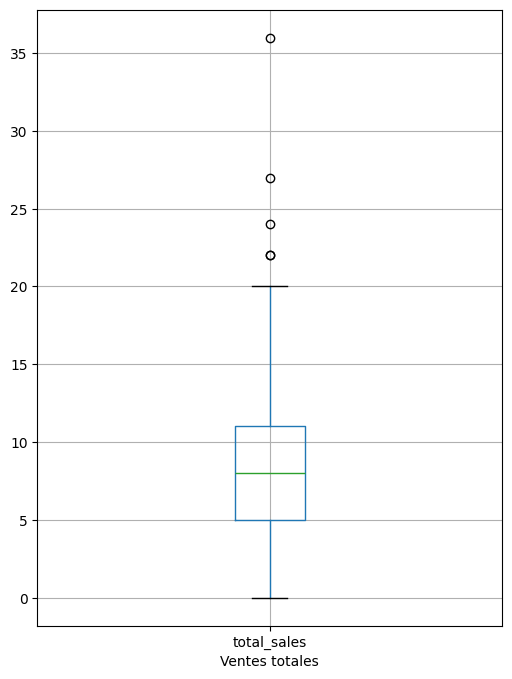

In [42]:
#Création d'une boîte à moustache de la répartition des prix grâce à Pandas
plt.figure(figsize=(6, 8))
df_fusion.boxplot(column=['total_sales'])
plt.xlabel('Ventes totales')
plt.show()

In [43]:
#Autre méthode avec plotly express
fig = px.box(
    data_frame=df_fusion,
    y="total_sales",
    title="Distribution des ventes",
    height=800,
    width=400
)

fig.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 4.2 - Exploration par l'utilisation de méthodes statistiques</h3>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 4.2.1 - Identification par le Z-index</h3>
</div>

In [44]:
#Calculer la moyenne du prix
mean_price = np.mean(df_fusion['price'])
print(f"Moyenne des prix : {mean_price:.2f}€")

#Calculer l'écart-type du prix
std_price = np.std(df_fusion['price'])
print(f"Ecart-type des prix : {std_price:.2f}€")

#Calculer le Z-score
# https://medium.com/@whyamit101/understanding-z-score-with-numpy-bc8b23f81639
df_fusion['z_score'] = (df_fusion['price'] - mean_price) / std_price
df_fusion.head()

Moyenne des prix : 32.32€
Ecart-type des prix : 27.59€


,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status,z_score
0,14692,5.0,2019-03-19 09:06:47,Vin,Château Fonréaud Bordeaux Blanc Le Cygne 2016,14692.0,5794,1,21.70,15,10.65,instock,-0.384764
1,15328,2.0,2019-03-27 17:05:09,Vin,Agnès Levet Côte Rôtie Maestria 2017,15328.0,5827,1,55.00,4,29.55,instock,0.822083
2,16515,10.0,2018-06-02 07:31:31,Vin,Château Turcaud Bordeaux Rouge Cuvée Majeure 2018,16515.0,4964,1,12.10,23,6.50,instock,-0.732684
3,16585,15.0,2018-02-16 13:03:16,Vin,Xavier Frissant Touraine Sauvignon 2019,16585.0,4223,1,9.70,42,4.81,instock,-0.819664
4,12869,7.0,2019-03-28 13:29:35,Vin,Stéphane Tissot Arbois D.D. 2016,12869.0,5900,1,18.25,21,8.96,instock,-0.509797


In [45]:
#Quel est le seuil prix dont le z-score est supérieur à 3?
df_fusion[df_fusion['z_score'] > 3]

,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status,z_score
153,14915,1.0,2019-01-15 14:30:49,Vin,Domaine Weinbach Gewurztraminer Grand Cru Furs...,14915.0,5612,1,124.8,19,66.41,instock,3.351750
210,15185,4.0,2019-03-13 13:43:22,Vin,Camille Giroud Clos de Vougeot 2016,15185.0,5767,1,175.0,12,90.42,instock,5.171081
212,7819,4.0,2018-03-22 10:42:48,Cognac,Cognac Frapin Château de Fontpinot 1989 20 Ans...,7819.0,4406,1,157.0,12,69.08,instock,4.518731
226,14220,3.0,2018-05-15 08:23:41,Vin,Domaine Des Croix Corton Charlemagne Grand Cru...,14220.0,4904,1,137.0,9,67.95,instock,3.793898
302,15126,5.0,2019-07-23 08:50:24,Vin,Domaine Clerget Echezeaux Grand Cru En Orveaux...,15126.0,6202,1,116.4,12,63.15,instock,3.047320
319,14983,6.0,2019-03-28 09:21:36,Champagne,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,14983.0,5892,1,191.3,98,116.06,instock,5.761819
392,14923,5.0,2019-06-28 15:22:27,Champagne,Champagne Gosset Célébris Vintage 2007,14923.0,6126,1,135.0,138,80.33,instock,3.721415
406,15070,2.0,2019-07-25 07:31:09,Vin,Domaine des Comtes Lafon Volnay 1er Cru Champa...,15070.0,6216,1,121.0,14,60.02,instock,3.214032
419,14775,3.0,2019-04-04 14:49:37,Whisky,Wemyss Malts Single Cask Scotch Whisky Choc 'n...,14775.0,5917,1,122.0,12,54.24,instock,3.250273
448,3510,3.0,2018-03-22 10:21:05,Cognac,Cognac Frapin VIP XO,3510.0,4402,1,176.0,11,78.25,instock,5.207322


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 4.2.2 - Identification par l'intervalle interquartile</h3>
</div>

In [46]:
#Utilisation de la fonction "describe" de Pandas pour l'étude des mesures de dispersion
df_fusion.describe()

,total_sales,post_date_gmt,sku_numeric,product_id,onsale_web,price,stock_quantity,purchase_price,z_score
count,713.000000,713,711.000000,713.000000,713.000000,713.000000,713.000000,713.000000,7.130000e+02
mean,8.054698,2018-08-21 21:01:14.868162816,14479.272855,5031.621318,0.998597,32.316620,23.478261,16.896438,2.242246e-17
min,0.000000,2018-02-08 11:58:52,38.000000,3847.000000,0.000000,5.200000,0.000000,2.740000,-9.827509e-01
25%,5.000000,2018-02-27 13:18:27,14368.500000,4280.000000,1.000000,14.050000,9.000000,7.240000,-6.620124e-01
50%,8.000000,2018-04-19 12:48:15,15382.000000,4795.000000,1.000000,23.400000,20.000000,12.280000,-3.231530e-01
75%,11.000000,2019-01-31 13:39:08,15880.500000,5711.000000,1.000000,42.000000,30.000000,22.030000,3.509416e-01
max,36.000000,2020-07-20 09:00:00,19822.000000,7338.000000,1.000000,225.000000,145.000000,137.810000,6.983163e+00
std,4.164265,NaN,3011.684168,790.669701,0.037450,27.611936,22.217449,14.836412,1.000702e+00


In [47]:
# Définir un seuil pour les articles "outliers" en prix
# https://www.geeksforgeeks.org/maths/outlier/
def calculate_limit(series: pd.Series, k: int = 1.5) -> tuple[float, float]:
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    limit_inf = max(0.0, Q1 - (k * IQR)) # J'ai mis une sécurité dans notre cas pour ne pas avoir de prix négatifs
    limit_sup = Q3 + (k * IQR)
    return (limit_inf, limit_sup)

In [48]:
#Définir le nombre d'articles et la proportion de l'ensemble du catalogue "outliers"
price_limit_inf, price_limit_sup = calculate_limit(df_fusion['price'])
print("Limites / seuils calculés :")
print(f"Limite inférieure : {price_limit_inf:.2f}€")
print(f"Limite supérieure : {price_limit_sup:.2f}€")

df_fusion[(df_fusion['price'] < price_limit_inf) | (df_fusion['price'] > price_limit_sup)]

Limites / seuils calculés :
Limite inférieure : 0.00€
Limite supérieure : 83.92€


,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status,z_score
53,11602,7.0,2018-07-17 08:52:41,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,11602.0,5008,1,105.0,12,56.42,instock,2.634165
85,3509,5.0,2018-03-22 10:49:53,Cognac,Cognac Frapin Cigar Blend,3509.0,4407,1,104.0,14,46.71,instock,2.597924
124,12791,3.0,2018-07-17 08:36:03,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,12791.0,5007,1,105.0,15,55.88,instock,2.634165
144,13996,7.0,2019-07-25 07:09:17,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,13996.0,6212,1,115.0,16,59.42,instock,2.996582
153,14915,1.0,2019-01-15 14:30:49,Vin,Domaine Weinbach Gewurztraminer Grand Cru Furs...,14915.0,5612,1,124.8,19,66.41,instock,3.351750
163,14596,6.0,2019-07-23 08:37:14,Vin,David Duband Chambolle-Musigny 1er Cru Les Sen...,14596.0,6201,1,105.6,16,57.29,instock,2.655910
210,15185,4.0,2019-03-13 13:43:22,Vin,Camille Giroud Clos de Vougeot 2016,15185.0,5767,1,175.0,12,90.42,instock,5.171081
212,7819,4.0,2018-03-22 10:42:48,Cognac,Cognac Frapin Château de Fontpinot 1989 20 Ans...,7819.0,4406,1,157.0,12,69.08,instock,4.518731
217,13853,7.0,2018-03-02 10:11:48,Champagne,Champagne Larmandier-Bernier Grand Cru Les Che...,13853.0,4359,1,85.6,112,51.93,instock,1.931077
226,14220,3.0,2018-05-15 08:23:41,Vin,Domaine Des Croix Corton Charlemagne Grand Cru...,14220.0,4904,1,137.0,9,67.95,instock,3.793898


In [49]:
#Selon vous, ces outliers sont-ils justifiés ? Comment le démontrer si cela est possible ?

Ces outliers sont justifiés, ils correspondent aux produits orientés pour des clients recherchant des produits rares ou d'une qualité supérieure.  
Ce qui explique ces prix anormalement élevés.

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Analyse univariée du CA, des quantités vendues, des stocks et de la marge ainsi qu'une analyse multivariée  </h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.1 - Analyse des ventes en CA</h3>
</div>

In [50]:
##############################
# Calculer le CA du site web #
##############################

#Créer une colonne calculant le CA par article

#Calculer la somme de la colonne "ca_par_article"
#Ce résultat correspond au chiffre d'affaire du site web
df_fusion['ca_par_article'] = df_fusion['total_sales'] * df_fusion['price']
df_fusion.head()


,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status,z_score,ca_par_article
0,14692,5.0,2019-03-19 09:06:47,Vin,Château Fonréaud Bordeaux Blanc Le Cygne 2016,14692.0,5794,1,21.70,15,10.65,instock,-0.384764,108.50
1,15328,2.0,2019-03-27 17:05:09,Vin,Agnès Levet Côte Rôtie Maestria 2017,15328.0,5827,1,55.00,4,29.55,instock,0.822083,110.00
2,16515,10.0,2018-06-02 07:31:31,Vin,Château Turcaud Bordeaux Rouge Cuvée Majeure 2018,16515.0,4964,1,12.10,23,6.50,instock,-0.732684,121.00
3,16585,15.0,2018-02-16 13:03:16,Vin,Xavier Frissant Touraine Sauvignon 2019,16585.0,4223,1,9.70,42,4.81,instock,-0.819664,145.50
4,12869,7.0,2019-03-28 13:29:35,Vin,Stéphane Tissot Arbois D.D. 2016,12869.0,5900,1,18.25,21,8.96,instock,-0.509797,127.75


In [51]:
###############################
# Palmarès des articles en CA #
###############################

#Effectuer le tri dans l'ordre décroissant du CA du dataset df_merge
df_fusion = df_fusion.sort_values('ca_par_article', ascending=False)

#Réinitialiser l'index du dataset par un reset_index
df_fusion = df_fusion.reset_index(drop=True)

#Afficher les 20 premiers articles en CA
df_fusion.head(20)


,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status,z_score,ca_par_article
0,15940,11.0,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,15940.0,4352,1,225.0,0,137.81,outofstock,6.983163,2475.0
1,14983,6.0,2019-03-28 09:21:36,Champagne,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,14983.0,5892,1,191.3,98,116.06,instock,5.761819,1147.8
2,12587,14.0,2018-03-02 09:37:26,Champagne,Champagne Egly-Ouriet Grand Cru Brut Rosé,12587.0,4353,1,79.5,127,45.91,instock,1.710003,1113.0
3,15325,20.0,2019-03-27 16:59:49,Vin,Agnès Levet Côte Rôtie Améthyste 2017,15325.0,5826,1,41.2,34,21.71,instock,0.321948,824.0
4,13996,7.0,2019-07-25 07:09:17,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,13996.0,6212,1,115.0,16,59.42,instock,2.996582,805.0
5,13913,9.0,2018-07-18 08:46:30,Champagne,Champagne Agrapart &amp; Fils Minéral Extra Br...,13913.0,5026,1,86.8,101,50.13,instock,1.974567,781.2
6,11602,7.0,2018-07-17 08:52:41,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,11602.0,5008,1,105.0,12,56.42,instock,2.634165,735.0
7,15185,4.0,2019-03-13 13:43:22,Vin,Camille Giroud Clos de Vougeot 2016,15185.0,5767,1,175.0,12,90.42,instock,5.171081,700.0
8,14923,5.0,2019-06-28 15:22:27,Champagne,Champagne Gosset Célébris Vintage 2007,14923.0,6126,1,135.0,138,80.33,instock,3.721415,675.0
9,13914,6.0,2018-07-18 08:39:43,Champagne,Champagne Agrapart &amp; Fils L'Avizoise Extra...,13914.0,5025,1,112.0,136,68.60,instock,2.887857,672.0


In [52]:
#Graphique en barre des 20 premiers articles avec plotly express
df_top_20_ca = df_fusion.head(20)

fig = px.bar(
    df_top_20_ca,
    x='ca_par_article',
    y='post_title',
    color='total_sales',
    title='Top 20 des articles par CA',
    orientation='h',
    labels={
        'ca_par_article': 'CA par article (€)',
        'post_title': 'Nom',
        'total_sales': 'Ventes'
    },
    height=800
)

fig.show()

In [53]:
#############################
# Calculer le 20 / 80 en CA #
#############################

#Créer une colonne calculant la part du CA de la ligne dans le dataset
ca_total = df_fusion['ca_par_article'].sum()
df_fusion['part_ca'] = ((df_fusion['ca_par_article'] / ca_total) * 100)

#Créer une colonne réalisant la somme cumulative de la colonne précedemment créée
df_fusion['ca_cumule'] = df_fusion['part_ca'].cumsum()

#Grâce aux deux colonnes créées précedemment, calculer le nombre d'articles représentant 80% du CA
nombre_article_80 = len(df_fusion[df_fusion['ca_cumule'] <= 80.0])
print(f"{nombre_article_80} des articles font 80% du CA.")

#Afficher la proportion que représente ce groupe d'articles dans le catalogue entier du site web
print(f"{(nombre_article_80 / len(df_fusion)) * 100:.2f}% de nos articles font 80% de notre CA.")


433 des articles font 80% du CA.
60.73% de nos articles font 80% de notre CA.


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.2 - Analyse des ventes en quantité</h3>
</div>

In [54]:
#####################################
# Palmarès des articles en quantité #
#####################################

#Effectuer le tri dans l'ordre décroissant de quantités vendues du dataset df_merge
df_fusion = df_fusion.sort_values('total_sales', ascending=False)

#Réinitialiser l'index du dataset par un reset_index
df_fusion = df_fusion.reset_index(drop=True)

#Afficher les 20 premiers articles en quantité
df_fusion.head()



,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status,z_score,ca_par_article,part_ca,ca_cumule
0,16148,36.0,2018-05-03 11:20:05,Vin,Château De La Selve IGP Coteaux de l'Ardèche M...,16148.0,4867,1,9.9,121,4.86,instock,-0.812415,356.4,0.248667,22.855961
1,15415,27.0,2018-02-15 13:33:42,Vin,Mas Laval IGP Pays d'Hérault Les Pampres Blanc...,15415.0,4203,1,9.9,74,5.01,instock,-0.812415,267.3,0.186500,40.090606
2,14864,24.0,2018-02-27 12:33:54,Vin,I Fabbri Chianti Classico Lamole 2017,14864.0,4275,1,14.9,62,7.78,instock,-0.631207,357.6,0.249504,21.611090
3,14950,22.0,2018-04-18 09:53:51,Vin,François Baur Pinot Noir Schlittweg 2017,14950.0,4726,1,12.7,0,6.82,outofstock,-0.710939,279.4,0.194943,36.650361
4,16525,22.0,2018-04-17 07:28:58,Vin,Bernard Baudry Chinon Rouge La Croix Boissée 2017,16525.0,4647,1,28.5,45,14.14,instock,-0.138321,627.0,0.437470,8.244671


In [55]:
#Graphique en barre des 20 premiers articles avec plotly express
df_top_20_ventes = df_fusion.head(20)

fig = px.bar(
    df_top_20_ventes,
    x='total_sales',
    y='post_title',
    color='ca_par_article',
    title='Top 20 des articles par ventes',
    orientation='h',
    labels={
        'ca_par_article': 'CA par article (€)',
        'post_title': 'Nom',
        'total_sales': 'Ventes'
    },
    height=800
)

fig.show()

In [56]:
#############################
# Calculer le 20 / 80 en CA #
#############################

#Créer une colonne calculant la part en quantité de la ligne dans le dataset
ventes_totales = df_fusion['total_sales'].sum()
df_fusion['part_vente'] = (df_fusion['total_sales'] / ventes_totales) * 100

#Créer une colonne réalisant la somme cumulative de la colonne précedemment créée
df_fusion['part_vente_cumule'] = df_fusion['part_vente'].cumsum()

#Grâce aux deux colonnes créées précedemment, calculer le nombre d'articles représentant 80% des ventes en quantité
nombre_article_80_vente = len(df_fusion[df_fusion['part_vente_cumule'] <= 80.0])
print(f"{nombre_article_80_vente} des articles font 80% des ventes.")

#Afficher la proportion que représente ce groupe d'articles dans le catalogue entier du site web
print(f"{(nombre_article_80_vente / len(df_fusion)) * 100:.2f}% des articles représentent 80% des ventes.")


432 des articles font 80% des ventes.
60.59% des articles représentent 80% des ventes.


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.3 - Analyse des stocks</h3>
</div>

In [57]:
######################################
# Calculer le nombre de mois de stock #
######################################

#Import de numpy 

#Création de la colonne Rotation de stock
#Remplacement des "inf" par 0
# https://www.erplain.com/fr/blog/calcul-rotation-stocks

df_fusion['rotation_stock'] = np.where(
    df_fusion['stock_quantity'] == 0,
    0,
    df_fusion['total_sales'] / df_fusion['stock_quantity']
)

MOIS_MAX_STOCK = 48
df_fusion['mois_de_stock'] = np.where(
    df_fusion['total_sales'] == 0,
    MOIS_MAX_STOCK,
    df_fusion['stock_quantity'] / df_fusion['total_sales']
)

#Effectuer le tri dans l'ordre décroissant du nombre de mois de stock dans le dataset df_merge
df_sans_article_fantome = df_fusion[~((df_fusion['total_sales'] == 0) & (df_fusion['stock_quantity'] == 0))]
df_sans_article_fantome = df_sans_article_fantome.sort_values('mois_de_stock', ascending=False)

#Graphique en barre du flop 20 des produits qui ont le plus de mois de stock
fig = px.bar(
    df_sans_article_fantome.head(20),
    x='mois_de_stock',
    y='post_title',
    color='stock_quantity',
    title='Top 20 des flops du mois',
    orientation='h',
    labels={
        'mois_de_stock': 'Mois de stock',
        'post_title': 'Nom',
        'stock_quantity': 'Stock physique'
    },
    height=800
)

fig.show()

In [58]:
####################################
# Valorisation des stocks en euros #
####################################

#Création de la colonne Valorisation des stocks en euros
df_fusion['valorisation_stock'] = df_fusion['stock_quantity'] * df_fusion['purchase_price']

#Calculer la somme de la colonne "Valorisation_stock_euros"
valeur_totale_stock = df_fusion['valorisation_stock'].sum()
print(f"Le stock vaut actuellement {valeur_totale_stock:.2f}€")

Le stock vaut actuellement 277328.07€


In [59]:
##############################################
# Valorisation du nombre de produits en stock #
##############################################

#Calculer la somme de la colonne stock quantity
nombre_articles_stock = df_fusion['stock_quantity'].sum()
print(f"Nombre d'articles actuellement en stock : {nombre_articles_stock}")

Nombre d'articles actuellement en stock : 16740


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.4 - Analyse du taux de marge</h3>
</div>

In [60]:
############################
# Analyse du taux de marge #
############################

#Création de la colonne Prix HT
#Création de la colonne Taux de marge
TAUX_TVA = 0.20

df_fusion = (
    df_fusion
    # Calcul du prix HT
    .assign(
        prix_ht = lambda x: x['price'] / (1 + TAUX_TVA)
    )
    # Calcul du taux de marge
    # Simplification du calcul ((prix_ht - purchase_price) / purchase_price) * 100
    .assign(
        taux_marge = lambda x: ((x['prix_ht'] / x['purchase_price']) - 1) * 100
    )
)


In [61]:
# Fonction qui affiche le min et max du taux de marge de nos dataframes
def affichage_min_max_marge(df: pd.DataFrame) -> None:
    id_marge_min = df['taux_marge'].idxmin()
    id_marge_max = df['taux_marge'].idxmax()

    ligne_marge_min = df.loc[id_marge_min]
    ligne_marge_max = df.loc[id_marge_max]

    print(f"Le produit avec la plus petite marge : '{ligne_marge_min['post_title']}' avec un taux de marge de : {ligne_marge_min['taux_marge']:.2f}")
    print(f"Le produit avec la plus grande marge : '{ligne_marge_max['post_title']}' avec un taux de marge de : {ligne_marge_max['taux_marge']:.2f}")

In [62]:
#Afficher le prix minimum de la colonne "taux_marge"
#Afficher le prix maximum de la colonne "taux_marge"
affichage_min_max_marge(df_fusion)


Le produit avec la plus petite marge : 'Champagne Egly-Ouriet Grand Cru Blanc de Noirs' avec un taux de marge de : -86.39
Le produit avec la plus grande marge : 'Cognac Frapin VSOP' avec un taux de marge de : 91.41


In [63]:
#Affichage de la ligne avec un taux de marge inférieur à 0
df_fusion[df_fusion['taux_marge'] < 0]


,sku,total_sales,post_date_gmt,product_type,post_title,sku_numeric,product_id,onsale_web,price,stock_quantity,...,ca_par_article,part_ca,ca_cumule,part_vente,part_vente_cumule,rotation_stock,mois_de_stock,valorisation_stock,prix_ht,taux_marge
689,12589,0.0,2018-03-02 09:46:10,Champagne,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,12589.0,4355,1,12.65,97,...,0.0,0.0,100.0,0.0,100.0,0.0,48.0,7515.56,10.541667,-86.394338


In [64]:
#Création d'un dataframe avec les taux positifs
df_marge: pd.DataFrame = df_fusion[df_fusion['taux_marge'] > 0]

#Afficher le prix minimum de la colonne "taux_marge"
#Afficher le prix maximum de la colonne "taux_marge"
affichage_min_max_marge(df_marge)


Le produit avec la plus petite marge : 'Huile d'Olive Extra Vierge Planeta 50cl' avec un taux de marge de : 29.50
Le produit avec la plus grande marge : 'Cognac Frapin VSOP' avec un taux de marge de : 91.41


In [65]:
#Création d'un dataframe avec le taux de marge moyen par type de produit
df_best_marge = df_marge.groupby(by='product_type', as_index=False)[['taux_marge']].mean()

#Affichage dans un graphique du taux de marge par type de produit
fig = px.bar(
    df_best_marge,
    x='product_type',
    y='taux_marge',
    title='Marge par type de produits',
    labels={
        'product_type': 'Type de produits',
        'taux_marge': 'Taux de marge'
    },
    height=600
)

fig.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.5 - Analyse des corrélations entre les variables stock, sales et price</h3>
</div>

<Axes: >

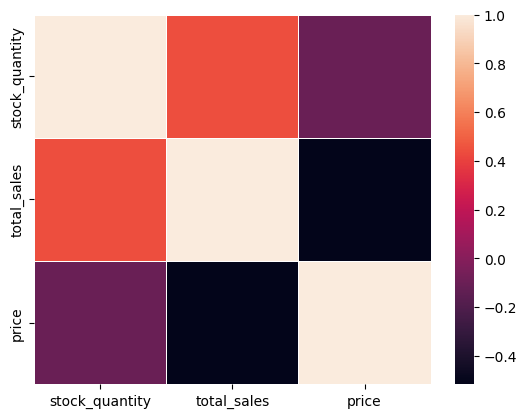

In [66]:
############################
# Analyse des corrélations #
############################

#Création d'une heatmap de corrélation avec les variables stock, sales et price
colonnes_corr = ['stock_quantity', 'total_sales', 'price']
matrice_correlation = df_fusion[colonnes_corr].corr()

sns.heatmap(
    matrice_correlation,
    cbar=True,
    linewidths=0.5
)

#On peut également créer un mask pour n'afficher qu'une demi heatmap

In [67]:
#Que peut-on conclure des corrélations ?

Voici ce que l'on peut conclure de cette matrice :
- Le stock et les prix ne présentent pas de relation linéaire significative. Leurs variations sont décorrélées, les décisions de pricing ne sont donc pas liées au niveau de l'inventaire.
- Il existe une corrélation positive modérée (environ +0.4) entre les ventes et le stock. Cette relation suggère que les articles les plus demandés bénéficient d'un niveau de stock suffisant pour éviter les ruptures, garantissant ainsi la continuité des ventes et répondant à la demande.
- La corrélation linéaire négative initiale (environ -0.4) est faible et ne reflète pas la complexité de la relation de demande-prix. Cette faiblesse indique la nécessité d'une analyse non-linéaire pour modéliser précisément l'impact réel d'un ajustement des prix.

Vu que la relation entre les ventes et le prix est peu élevé, on peut regarder si la relation est plutôt de type logarithmique

In [ ]:
# Scatter plot pour plus d'analyse pour la relation prix / vente
fig = px.scatter(
    df_fusion,
    x='price',
    y='total_sales',
    title='Nuage de points : Ventes en fonction du prix',
    height=600,
    trendline='ols',
    trendline_options=dict(log_x=True),
    trendline_color_override="red",
    labels={
        'total_sales': 'Ventes',
        'price': 'Prix'
    }
)

fig.show()

Avec ce graphe supplémentaire, on peut remarque que la relation entre les ventes et le prix n'est pas linéaire mais bien logarithmique. 
On voit clairement une chute importante des ventes avec l'augmentation des prix, avec une régression plus linéaire à partir de 50€ 

In [90]:
# Scatter plot pour plus d'analyse pour la relation stock / vente
fig = px.scatter(
    df_fusion[df_fusion['stock_quantity'] > 0],
    x='stock_quantity',
    y='total_sales',
    title='Nuage de points : Ventes en fonction du stock',
    height=600,
    labels={
        'total_sales': 'Ventes',
        'stock_quantity': 'Stock'
    }
)

fig.show()

On peut très vite remarquer qu'un stock très important n'a aucun rapport direct sur le nombre de vente.
Au contraire les stocks importants peuvent expliquer un nombre de ventes faibles impliquant ces écarts. 

Malgré tout, si on omet ces écarts, les ventes et les stocks semblent avoir une relation linéaire, montrant des ventes régulières.

In [92]:
# Scatter plot pour plus d'analyse pour la relation stock / vente avec un stock inférieur à 60 (écarts)
fig = px.scatter(
    df_fusion[(df_fusion['stock_quantity'] > 0) & (df_fusion['stock_quantity'] < 60)],
    x='stock_quantity',
    y='total_sales',
    title='Nuage de points : Ventes en fonction du stock (écarts de stock retirés)',
    height=600,
    trendline='ols',
    trendline_color_override='red',
    labels={
        'total_sales': 'Ventes',
        'stock_quantity': 'Stock'
    }
)

fig.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.6 - Mise à disposition de la nouvelle table sur un fichier Excel</h3>
</div>

In [69]:
#Mettre le dataset df_merge sur un fichier Excel
#Cette étape peut être utile pour partager le résultat du dataset obtenu avec les équipes.  
df_fusion.to_excel('bottleneck_stock.xlsx')